In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
# Import optimization functions from SciPy
from scipy.optimize import differential_evolution, minimize, OptimizeResult, brentq
# - `differential_evolution`: Global optimization using genetic algorithms.
# - `minimize`: General-purpose minimization function for various algorithms.
# - `OptimizeResult`: A class that holds the results of an optimization process.
# - `brentq`: Root-finding algorithm for solving a single variable function.

# Import NumPy for numerical computations
import numpy as np  

# Import numdifftools for numerical differentiation
import numdifftools as nd  

# Import Matplotlib for plotting and animations
import matplotlib.pyplot as plt  
import matplotlib.animation as animation  

# Import time module for measuring execution time
import time  

# Import Qiskit components for quantum computing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble
# - `QuantumCircuit`: Defines a quantum circuit.
# - `QuantumRegister`: Represents a set of qubits in a quantum circuit.
# - `ClassicalRegister`: Holds classical bits for measurement.
# - `transpile`: Optimizes quantum circuits for specific quantum backends.
# - `assemble`: Converts a circuit into a format suitable for execution on a simulator or quantum device.

# Import Aer simulator from Qiskit for running quantum circuits
from qiskit_aer import Aer  

# Import quantum gates from Qiskit’s circuit library
from qiskit.circuit.library.standard_gates import HGate, SGate, SdgGate, RYGate, CXGate
# - `HGate`: Hadamard gate (creates superposition).
# - `SGate`: S (phase) gate (applies π/2 phase shift).
# - `SdgGate`: S† (inverse S gate, applies -π/2 phase shift).
# - `RYGate`: Rotation around the Y-axis.
# - `CXGate`: CNOT (controlled-X) gate for entanglement.

from qiskit.circuit.library import XGate, RXGate, CCXGate, CRXGate, RZGate, CRZGate, SwapGate, QFT
# - `XGate`: Pauli-X gate (acts like a classical NOT gate).
# - `RXGate`: Rotation around the X-axis.
# - `CCXGate`: Toffoli gate (controlled-controlled-X).
# - `CRXGate`: Controlled-RX rotation gate.
# - `RZGate`: Rotation around the Z-axis.
# - `CRZGate`: Controlled-RZ rotation gate.
# - `SwapGate`: Swaps the states of two qubits.
# - `QFT`: Quantum Fourier Transform gate sequence.

# Import quantum information processing tools from Qiskit
from qiskit.quantum_info import Operator, SparsePauliOp, Statevector, partial_trace, DensityMatrix
# - `Operator`: Represents a quantum operator.
# - `SparsePauliOp`: Efficient representation of Pauli operators.
# - `Statevector`: Represents quantum state vectors.
# - `partial_trace`: Computes the reduced density matrix by tracing out qubits.
# - `DensityMatrix`: Represents mixed quantum states.

# Import tqdm for progress bars in loops
from tqdm import tqdm  

# Import product function from itertools for creating Cartesian products
from itertools import product  

# Import datetime for handling date and time
import datetime  

### Custom Imports

In [3]:
#from ansatz_circuit_Ollitrault_n_qubits import get_full_variational_quantum_circuit
from ComparisonMaker import get_less_than_operations, get_less_than_logic_explanation
from CustomOperations import * #imports CCRX, AND, OR, CQFT, and their inverses
from vff_ansatz_8q_up import get_full_vff_quantum_circuit, get_full_vff_quantum_circuit_with_phases

# How many qubits?

In [4]:
QUBITS_NUM = 8 #number of Position Register qubits (longer runtime scales exponentially with number of qubits)
ANCILLA_QUBITS = 4
COMPARISON_QUBITS = 2

total_qubits = QUBITS_NUM + ANCILLA_QUBITS + COMPARISON_QUBITS

start_time = 0.0 #start time
timestep = 10.0 #Trotter step size (smaller step size, longer runtime, scales linearly)
stop_time = 491.0 #stop time (longer stop_time, longer runtime total, scales linearly)
trial = 3.0
diabaticity = 0.100

IntegratedCoupling = 0.00792665 #integral from -inf to inf of 0.01*e^(-5x^2)

numbers = [127, 129] #where are your breakpoints?

In [5]:
current_time = int(time.time())
simulator_backend = Aer.get_backend('qasm_simulator')

# **TROTTER-SUZUKI** Parameters

In [6]:
m = 1818.18 #mass term
L = 20 #box size
d = L/2 #Box is defined from (-d to d)

N = 2**QUBITS_NUM #number of states

x_0 = 1.5 #horizontal offset of initialized Gaussian wavepacket
p_0 = -30.0 #momentum of initialized Gaussian wavepacket
δ = 1.0/3.0 #width of initialized Gaussian wavepacket

Δ_x = L / N #position grid spacing
Δ_p  = 2*np.pi / (N * Δ_x) #momentum grid spacing

Nyquist = np.pi / Δ_x #max / min momentum

center = 0 #center of box

V1_strength = 0.015
V2_strength = 0.015

offset = center + 1.5 #offset for first quadratic potential
offset_2 = center - 1.5 #offset for second quadratic potential
statevector = []

ħ = 1.0 #atomic units for hbar

step_phase = (IntegratedCoupling / ((Δ_x)*(numbers[1] - numbers[0] + 1)))* timestep #strength of coupling

#Filenames
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
trotter_anc_filename = f"{current_date}_{QUBITS_NUM}q_trotter_ancilla_states_marcus_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}_alpha{diabaticity}.txt"
trotter_sv_filename = f"{current_date}_{QUBITS_NUM}q_trotter_statevectors_marcus_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}_alpha{diabaticity}.txt"
trotter_mom_filename = f"{current_date}_{QUBITS_NUM}q_trotter_momentum_after_cqft_marcus_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}_alpha{diabaticity}.txt"

vff_anc_filename = f"{current_date}_{QUBITS_NUM}q_vff_ancilla_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"
vff_sv_filename = f"{current_date}_{QUBITS_NUM}q_vff_statevectors_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"
vff_mom_filename = f"{current_date}_{QUBITS_NUM}q_vff_momentum_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"

pvff_anc_filename = f"{current_date}_{QUBITS_NUM}q_pvff_ancilla_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"
pvff_sv_filename = f"{current_date}_{QUBITS_NUM}q_pvff_statevectors_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"
pvff_mom_filename = f"{current_date}_{QUBITS_NUM}q_pvff_momentum_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"

#The same ancilla qubit can be used in the entire circuit. A second one helps with clarity, but is unnecessary
ancilla_register = QuantumRegister(ANCILLA_QUBITS, name="ancilla")
ancilla_circuit = QuantumCircuit(ancilla_register)

#One qubit is the objective qubit, whose rotations are controlled by the position register
#n comparator qubits are used to store positions for n breakpoints (this example, three breakpoints)
comparison_register = QuantumRegister(COMPARISON_QUBITS, name="comparison")
comparison_circuit = QuantumCircuit(comparison_register)

#A recreation of the initial circuit, to define a register that represents qubit positions
position_register = QuantumRegister(QUBITS_NUM, name="position")
position_circuit = QuantumCircuit(position_register)

# Helper Functions

In [7]:
def record_ancilla_state_z_basis_single_tau(main_circuit, ancilla_register, tau, filename="ancilla_states.txt"):

    # Set up the statevector simulator
    simulator = Aer.get_backend('statevector_simulator')

    # Transpile the circuit for the simulator
    transpiled_circuit = transpile(main_circuit, simulator)

    # Run the simulation and get the statevector
    result = simulator.run(transpiled_circuit).result()
    statevector = Statevector(result.get_statevector())

    # Get the Pauli-Z operator for the ancilla qubit
    pauli_z = np.array([[1, 0], [0, -1]])

    ancilla_index = main_circuit.find_bit(ancilla_register[0]).index
    
    # Apply the Pauli-Z operator to the ancilla qubit in the statevector
    z_expectation_value = np.real(statevector.expectation_value(Operator(pauli_z), [ancilla_index]))
    population_fraction = (z_expectation_value + 1) / 2
    # Append the result to the file in a new line, tab-separated
    with open(filename, "a") as file:
        file.write(f"{tau}\t{population_fraction}\n")

# Trace out Position Register from Ancilla, Comparison registers

In [8]:
def isolate_position_density_matrix(statevector, ancilla_indices, comparison_indices):
    # Convert statevector to a density matrix
    rho = DensityMatrix(statevector)

    # Perform the partial trace over the ancilla and comparison registers
    reduced_rho = partial_trace(rho, ancilla_indices + comparison_indices)

    return reduced_rho  # Return the density matrix directly

# Record Statevectors over Time for Animation

In [9]:
def record_statevectors_over_time(main_circuit, tau, filename="statevectors_over_time.txt"):
    # Set up the statevector simulator backend
    simulator = Aer.get_backend('statevector_simulator')

    # Transpile the circuit for the simulator
    transpiled_circuit = transpile(main_circuit, simulator)

    # Run the simulation and get the full statevector
    result = simulator.run(transpiled_circuit).result()
    statevector = Statevector(result.get_statevector())

    # Extract the qubit registers
    position_register = main_circuit.qregs[0]  # Assuming position_register is the first qreg
    ancilla_register = main_circuit.qregs[1]   # Adjust indices if needed
    comparison_register = main_circuit.qregs[2]

    # Get the qubit indices for each register
    position_indices = [main_circuit.find_bit(q).index for q in position_register]
    ancilla_indices=tuple(range(QUBITS_NUM, QUBITS_NUM + ANCILLA_QUBITS))
    comparison_indices=tuple(range(QUBITS_NUM + ANCILLA_QUBITS, total_qubits))

    # Isolate the density matrix for the position register
    reduced_rho = isolate_position_density_matrix(
        statevector, ancilla_indices, comparison_indices
    )

    # Extract the real part of the diagonal elements (probabilities for each state)
    statevector_real = np.real(np.diag(reduced_rho.data))

    N = len(statevector_real)
    position_range = np.linspace(-d, d, N)  # Map states to [-10, 10]
    
    with open(filename, "a") as file:
        file.write(f"{tau}\t")
        file.write("\t".join(f"{component:.6f}" for component in statevector_real))
        file.write("\n")

# Record Momentum Distribution after CQFT

In [10]:
def record_momentum_distribution(circuit, position_register, tau, filename="momentum_distribution.txt"):
    simulator = Aer.get_backend('statevector_simulator')
    transpiled_circuit = transpile(circuit, simulator)
    result = simulator.run(transpiled_circuit).result()
    statevector = Statevector(result.get_statevector())

    ancilla_indices=tuple(range(QUBITS_NUM, QUBITS_NUM + ANCILLA_QUBITS))
    comparison_indices=tuple(range(QUBITS_NUM + ANCILLA_QUBITS, total_qubits))
    
    # Get reduced density matrix for position register
    rho_position = isolate_position_density_matrix(
        statevector,
        ancilla_indices=ancilla_indices,
        comparison_indices=comparison_indices
    )
    
    # Get probabilities
    probabilities = np.real(np.diag(rho_position.data))
    probabilities = np.flip(probabilities)
    
    # Write to file: time followed by all probabilities
    with open(filename, "a") as file:
        file.write(f"{tau}\t" + "\t".join(f"{prob:.6f}" for prob in probabilities) + "\n")

# Calculate Potentials for Visualization

In [11]:
def calculate_potential_from_bits(x_values, QUBITS_NUM, d, Δ_x, V1_strength, offset, ħ, vertical_off = diabaticity):
    β = (-d + (Δ_x / 2) - offset)/(Δ_x * QUBITS_NUM)
    γ = V1_strength * (Δ_x)**2 / ħ
    
    potentials = np.zeros_like(x_values)
    
    for idx, x in enumerate(x_values):
        # Convert position to binary representation
        normalized_pos = (x + d) / (2 * d)  # Map from [-d,d] to [0,1]
        if 0 <= normalized_pos <= 1:
            binary_val = int(normalized_pos * (2**QUBITS_NUM))
            binary_seq = [(binary_val >> j) & 1 for j in range(QUBITS_NUM)]
            
            # Calculate potential using the exponential formula
            potential = 0
            for j in range(QUBITS_NUM):
                for l in range(QUBITS_NUM):
                    k_j = binary_seq[j]
                    k_l = binary_seq[l]
                    term = γ * (k_j * 2**j + β) * (k_l * 2**l + β) 
                    potential += term
            potentials[idx] = potential + vertical_off
        else:
            potentials[idx] = np.nan  # Outside valid range
            
    return potentials

# Initialize Gaussian Wavepacket

In [12]:
def initialize_gaussian_wavepacket(x_0, p_0, δ):
    # Initialize empty state vector
    psi = np.zeros(N, dtype=complex)
    
    # Correct normalization factor for Gaussian wavepacket
    norm_factor = (1/(2*np.pi*δ**2))**(1/4)
    #print(f"Initial norm factor: {norm_factor}")
    
    # Calculate wavefunction for each position
    for position in range(N):
        x = -d + position * Δ_x
        
        # Gaussian envelope
        gaussian = np.exp(-(x - x_0)**2 / (4*δ**2))*np.exp(1j*p_0*(x-x_0))
        #gaussian = np.exp(-(x - x_0)**2 / (4*δ**2))
        psi[position] = gaussian
    
    # Apply normalization factor
    psi = norm_factor * psi
    
    # Check intermediate normalization
    intermediate_norm = np.sqrt(np.sum(np.abs(psi)**2 * Δ_x))
    #print(f"Norm after applying norm_factor: {intermediate_norm}")
    
    # Discrete normalization for quantum circuit
    final_norm = np.sqrt(np.sum(np.abs(psi)**2))
    psi = psi / final_norm
    
    # Verify final normalization
    verification_norm = np.sqrt(np.sum(np.abs(psi)**2))
    #print(f"Final verification norm: {verification_norm}")
    
    # Print some wavefunction values for verification
    #print(f"Max amplitude: {np.max(np.abs(psi))}")
    #print(f"Wavefunction at x_0: {psi[int((x_0 + d)/Δ_x)]}")
    
    return psi

# Debugging function: record high bit state

In [13]:
def record_high_bit_state(circuit, position_register, tau, filename="high_bit_states.txt"):
    # Set up the statevector simulator
    simulator = Aer.get_backend('statevector_simulator')
    
    # Transpile the circuit
    transpiled_circuit = transpile(circuit, simulator)
    
    # Run the simulation and get the statevector
    result = simulator.run(transpiled_circuit).result()
    statevector = Statevector(result.get_statevector())
    
    # Get the Pauli-Z operator for the high bit
    pauli_z = np.array([[1, 0], [0, -1]])
    
    # Get index of the highest bit in position register
    high_bit_index = circuit.find_bit(position_register[QUBITS_NUM - 1]).index
    
    # Calculate expectation value of Z for highest bit
    z_expectation = np.real(statevector.expectation_value(Operator(pauli_z), [high_bit_index]))
    
    # Convert to probability of being in |1⟩ state: (1 - ⟨Z⟩)/2
    prob_one = (1 - z_expectation) / 2
    
    # Append results to file
    with open(filename, "a") as file:
        file.write(f"{tau}\t{prob_one}\n")

# Get Expectation Values Over Time

In [14]:
def calculate_expectation_value(probabilities, positions, box_size=20):
    # Change box_size parameter and position mapping
    x_min = -d
    x_max = d
    box_size = x_max - x_min
    scaling = box_size / len(positions)
    real_positions = np.linspace(x_min, x_max, len(positions))
    return -np.sum(probabilities * real_positions)

# Trial: First Potential Surface, Applied Alone, Not controlled by Ancilla

In [15]:
def zeroth_order_operations(angle, circuit, ancilla, target):
    circuit.cp(angle, ancilla, target)
    circuit.cx(ancilla, target)
    circuit.cp(angle, ancilla, target)
    circuit.cx(ancilla, target)

In [16]:
def first_order_operations(angle, circuit, ancilla, position_register):
    for qubit in range(QUBITS_NUM):
        bit_order = qubit
        position_scaling = 2**bit_order
        target = position_register[bit_order]
        circuit.cp(angle * position_scaling, ancilla, target)

In [17]:
def second_order_operations(angle, circuit, ancilla, intermediate, position_register):
    for control in range(QUBITS_NUM):
        bit_order = 2*(control)
        position_scaling = 2**(bit_order)
        circuit.cp(angle*position_scaling, ancilla, position_register[control])
        for target in range(QUBITS_NUM):
            if target != control:
                bit_order = (control) + (target)
                position_scaling = 2**(bit_order)
                circuit.ccx(ancilla, position_register[control], intermediate)
                circuit.cp(angle*position_scaling, intermediate, position_register[target])
                circuit.ccx(ancilla, position_register[control], intermediate)

# Kinetic Term

In [18]:
kinetic_vdag_params = [2.413950794397081,
0.7514576447243354,
2.5783396187200434,
0.4891360458853714,
1.13080848840394,
3.121962446381416,
1.9352917523266782,
4.1292690615680865,
1.1955482310169643,
5.7765318940027,
1.0848345088545621,
4.205062297197694,
5.306815798887666,
0.6190829100310004,
3.110426032403513,
1.0855984914888996,
3.8320183215730514,
3.317871496745463,
3.8364067539688267,
4.654187305399899,
1.6565351466180374,
0.5792896832947799,
3.95422857856652,
6.13368419053228,
1.6609110973968089,
1.3830807587508915,
2.062595380976651,
5.834817136719867,
2.817098230123146,
5.869466579642528,
6.213974414363335,
6.145306827391403,
6.009600247474552,
5.74470557076669,
5.240954379852836,
4.33768841621539,
2.948045650954499,
1.8363316804463752]

kinetic_params = [param for param in kinetic_vdag_params]
#Need to multiply by factor of number of timesteps for time evolution (1, 2, 3, 4, etc. for 10a.u., 20a.u., 30a.u., etc.)

In [19]:
num_layers_eigenvector = 2
num_layers_diagonal = 1

In [20]:
def calculate_parameter_counts(num_layers_eigenvector, num_layers_diagonal, QUBITS_NUM):
        w_params_per_layer = QUBITS_NUM + (QUBITS_NUM // 2) + ((QUBITS_NUM - 1)//2)
        total_w_params = (num_layers_eigenvector * w_params_per_layer)
        d_params_per_layer = QUBITS_NUM
        total_d_params = num_layers_diagonal * d_params_per_layer
        return total_w_params, total_d_params

In [21]:
def build_vff_ansatz(params):
    total_w_params, total_d_params = calculate_parameter_counts(num_layers_eigenvector, num_layers_diagonal, QUBITS_NUM)
    
    return get_full_vff_quantum_circuit(
        params, 
        num_layers_eigenvector, 
        num_layers_diagonal, 
        QUBITS_NUM
    )

In [22]:
def apply_kinetic_term_with_phases(circuit, params_w_d, phase_params, number, τ):
    total_w_params, total_d_params = calculate_parameter_counts(num_layers_eigenvector, num_layers_diagonal, QUBITS_NUM)
    w_params = params_w_d[:total_w_params]
    d_params = params_w_d[total_w_params:]
    
    # Apply time evolution to diagonal parameters only
    time_evolution = [param * number for param in d_params]
    evolved_params = w_params + time_evolution
    
    # Create the VFF ansatz circuit with phase parameters

    vff_circuit = get_full_vff_quantum_circuit_with_phases(
        evolved_params, 
        phase_params,
        num_layers_eigenvector, 
        num_layers_diagonal, 
        QUBITS_NUM
    )
    
    # Extract the instructions from the VFF circuit and add them to the main circuit
    for instruction in vff_circuit.data:
        qubits = []
        for i, qubit in enumerate(instruction.qubits):
            qubit_idx = vff_circuit.find_bit(qubit).index
            qubits.append(position_register[qubit_idx])
        circuit.append(instruction.operation, qubits, [])

In [ ]:
def check_phase_shift(vff_circuit, target_circuit):
    test_state = np.zeros(2**Config.QUBITS_NUM, dtype=complex)
    test_state[0] = 1.0  # |0...0> state
    
    # Apply both circuits
    vff_result = vff_circuit @ test_state
    target_result = target_circuit @ test_state
    
    # Check if vff_result = e^(iφ) * target_result
    ratio = vff_result / target_result
    phases = np.angle(ratio[np.abs(ratio) > 1e-10])
    
    print(f"Phase differences: {phases}")
    print(f"Phase range: {phases.max() - phases.min()}")
    
    # If the range is small, we have a global phase
    if phases.max() - phases.min() < 0.01:
        global_phase = np.mean(phases)
        print(f"Global phase detected: {global_phase}")
        
        # This phase can cause velocity shift
        velocity_shift = -global_phase / Config.TIMESTEP
        print(f"Corresponding velocity shift: {velocity_shift}")

In [23]:
def apply_kinetic_term(circuit, params, number, τ):
    total_w_params, total_d_params = calculate_parameter_counts(num_layers_eigenvector, num_layers_diagonal, QUBITS_NUM)
    w_params = params[:total_w_params-1]
    d_params = params[total_w_params-1:]
    time_evolution = [param * number for param in d_params]
    new_params = w_params + time_evolution
    
    # Create the VFF ansatz circuit for position register qubits only
    vff_circuit = build_vff_ansatz(new_params)
    
    
    # Extract the instructions from the VFF circuit and add them to the main circuit
    # targeting only the position register qubits
    for instruction in vff_circuit.data:
        qubits = []
        for i, qubit in enumerate(instruction.qubits):
            # Map each qubit from the VFF circuit to the corresponding position register qubit
            qubit_idx = vff_circuit.find_bit(qubit).index  # Get the index in the original circuit
            qubits.append(position_register[qubit_idx])  # Use that index in position_register
            
        # Append the operation to the main circuit with the mapped qubits
        circuit.append(instruction.operation, qubits, [])

# Marcus Model: Two Harmonic Potentials

In [24]:
def marcus_kinetic_term(circuit, position_register, QUBITS_NUM, τ):
    # Modified coefficients to center around target momentum
    #β = (-Nyquist - p_0)/(Δ_p)
    β = (-Nyquist - p_0)/(Δ_p)
    γ = (Δ_p)**2 / (2*m*ħ)
    
    θ_1 = -τ*(γ*β**2)
    θ_2 = -2*τ*γ*β
    θ_3 = -τ*γ
    
    # Apply quadratic phase
    circuit.p(θ_1, position_register[0])
    circuit.x(position_register[0])
    circuit.p(θ_1, position_register[0])
    circuit.x(position_register[0])

    # Apply linear phase for momentum shift
    for qubit in range(QUBITS_NUM):
        bit_order = qubit
        position_scaling = 2**bit_order
        circuit.p(θ_2 * position_scaling, position_register[bit_order])

    # Apply kinetic energy operator
    for control in range(QUBITS_NUM):
        bit_order = 2*(control)
        position_scaling = 2**(bit_order)
        circuit.p(θ_3*position_scaling, position_register[control])
        for target in range(QUBITS_NUM):
            if target != control:
                bit_order = (control) + (target)
                position_scaling = 2**(bit_order)
                circuit.cp(θ_3*position_scaling, position_register[control], position_register[target])

    return circuit

In [25]:
def HarmonicPotential(circuit, position_register, ancilla_register, τ, potentialnum):
    ancilla_control = ancilla_register[0]
    
    if potentialnum == 1:
        circuit.x(ancilla_control)
        VertOffset = diabaticity
        HorizOffset = offset
        Strength = V1_strength
    elif potentialnum == 2: 
        HorizOffset = offset_2
        VertOffset = 0.0
        Strength = V2_strength

    β = (-d - HorizOffset + (Δ_x)/2)/(Δ_x)
    γ = Strength * (Δ_x)**2 / (ħ)
    
    θ_1 = -τ*(γ*β**2 + VertOffset)
    θ_2 = -2*τ*γ*β
    θ_3 = -τ*γ

    # Apply quadratic phase
    zeroth_order_operations(θ_1, circuit, ancilla_control, position_register[0])

    # Apply linear phase for position shift
    first_order_operations(θ_2, circuit, ancilla_control, position_register)

    # Apply potential energy operator
    second_order_operations(θ_3, circuit, ancilla_control, ancilla_register[1], position_register)

    if potentialnum == 1:
        circuit.x(ancilla_control)

    return circuit

# Coupling Potential Terms

In [26]:
def bigger_step_coupling(circuit, position_register, ancilla_register, comparison_register):
    ctrl1 = comparison_register[0]
    ctrl2 = comparison_register[1]
    target = ancilla_register[0]
    circuit.x(ctrl1)
    ccrx(circuit, step_phase, ctrl1, ctrl2, target)
    circuit.x(ctrl1)

# Define Breakpoint Checks

In [27]:
def lessthanlogic0(position_register, ancilla_register, comparison_register):
    logic = []
    logic.extend(OR(position_register[0], position_register[1], ancilla_register[1]))
    logic.extend(OR(position_register[2], position_register[3], ancilla_register[2]))
    logic.extend(OR(ancilla_register[1], ancilla_register[2], ancilla_register[3]))
    logic.extend(invOR(position_register[2], position_register[3], ancilla_register[2]))
    logic.extend(invOR(position_register[0], position_register[1], ancilla_register[1]))
    logic.extend(OR(position_register[4], position_register[5], ancilla_register[1]))
    logic.extend(OR(ancilla_register[1], ancilla_register[3], ancilla_register[2]))
    logic.extend(invOR(position_register[4], position_register[5], ancilla_register[1]))
    logic.extend(OR(position_register[6], ancilla_register[2], ancilla_register[1]))
    
    logic.extend(AND(position_register[7], ancilla_register[1], comparison_register[0]))
    
    logic.extend(invOR(position_register[6], ancilla_register[2], ancilla_register[1]))
    logic.extend(OR(position_register[4], position_register[5], ancilla_register[1]))
    logic.extend(invOR(ancilla_register[1], ancilla_register[3], ancilla_register[2]))
    logic.extend(invOR(position_register[4], position_register[5], ancilla_register[1]))
    logic.extend(OR(position_register[0], position_register[1], ancilla_register[1]))
    logic.extend(OR(position_register[2], position_register[3], ancilla_register[2]))
    logic.extend(invOR(ancilla_register[1], ancilla_register[2], ancilla_register[3]))
    logic.extend(invOR(position_register[2], position_register[3], ancilla_register[2]))
    logic.extend(invOR(position_register[0], position_register[1], ancilla_register[1]))  
    return logic

def lessthanlogic1(position_register, ancilla_register, comparison_register):
    logic = []
    logic.extend(AND(position_register[0], position_register[1], ancilla_register[1]))
    logic.extend(AND(position_register[2], position_register[3], ancilla_register[2]))
    logic.extend(AND(ancilla_register[1], ancilla_register[2], ancilla_register[3]))
    logic.extend(invAND(position_register[2], position_register[3], ancilla_register[2]))
    logic.extend(invAND(position_register[0], position_register[1], ancilla_register[1]))
    logic.extend(AND(position_register[4], position_register[5], ancilla_register[1]))
    logic.extend(AND(ancilla_register[1], ancilla_register[3], ancilla_register[2]))
    logic.extend(invAND(position_register[4], position_register[5], ancilla_register[1]))
    logic.extend(AND(position_register[6], ancilla_register[2], ancilla_register[1]))
    logic.extend(OR(position_register[7], ancilla_register[1], comparison_register[1]))
    return logic

In [28]:
def logics(position_register, ancilla_register, comparison_register):
    logic0 = lessthanlogic0(position_register, ancilla_register, comparison_register)
    logic1 = lessthanlogic1(position_register, ancilla_register, comparison_register)
    all_bps = {numbers[0]: logic0, numbers[1]: logic1}  # Use a dictionary with breakpoint numbers as keys
    return all_bps

def create_breakpoint_operations(number, logics, position_register, ancilla_register, comparison_register):
    return logics.get(number, [])  # Get operations for this breakpoint number

def create_combined_operations(numbers, n_bits, logics, position_register, ancilla_register, comparison_register):
    all_operations = []
    explanations = {}
    
    # First number (131)
    first_number = numbers[0]
    result1 = get_less_than_operations(first_number, n_bits)
    explanations[first_number] = result1["explanation"]
    
    # X gates for first number
    x_gate_operations1 = []
    for bit_pos in result1["x_gate_positions"]:
        x_gate_operations1.append((XGate(), [position_register[bit_pos]]))
    
    # Logic operations for first number
    bp_operations1 = create_breakpoint_operations(first_number, logics, position_register, ancilla_register, comparison_register)
    
    # Add first number operations
    all_operations.extend(x_gate_operations1)
    all_operations.extend(bp_operations1)
    
    # Add undo X gates for first number
    for bit_pos in result1["x_gate_positions"]:
        all_operations.append((XGate(), [position_register[bit_pos]]))
    
    # Second number (133)
    second_number = numbers[1]
    result2 = get_less_than_operations(second_number, n_bits)
    explanations[second_number] = result2["explanation"]
    
    # X gates for second number
    x_gate_operations2 = []
    for bit_pos in result2["x_gate_positions"]:
        x_gate_operations2.append((XGate(), [position_register[bit_pos]]))
    
    # Logic operations for second number
    bp_operations2 = create_breakpoint_operations(second_number, logics, position_register, ancilla_register, comparison_register)
    
    # Add second number operations
    all_operations.extend(x_gate_operations2)
    all_operations.extend(bp_operations2)
    
    return all_operations, explanations

def check_all_breakpoints(main_circuit, operations):
    for gate, qubits in operations:
        main_circuit.append(gate, qubits)

def uncheck_all_breakpoints(main_circuit, operations):
    for gate, qubits in reversed(operations):
        main_circuit.append(gate, qubits)

In [29]:
def apply_x_gates(main_circuit, bit_positions, position_register):
    for bit_pos in bit_positions:
        main_circuit.append(XGate(), [position_register[bit_pos]])

def apply_comparison_logic(main_circuit, number, logic):
    bp_operations = logic.get(number, [])
    for gate, qubits in bp_operations:
        main_circuit.append(gate, qubits)

def handle_comparison(main_circuit, number, position_register, logic, undo_x_gates=False):
    # Get comparison operations for this number
    result = get_less_than_operations(number, QUBITS_NUM)
    
    # Apply X gates
    x_positions = result["x_gate_positions"]
    apply_x_gates(main_circuit, x_positions, position_register)
    
    # Apply comparison logic
    apply_comparison_logic(main_circuit, number, logic)
    
    # Undo X gates if requested
    if undo_x_gates:
        apply_x_gates(main_circuit, x_positions, position_register)
    
    return result["explanation"], x_positions

def comparator_circuit(numbers, logic, position_register, ancilla_register, comparison_register, main_circuit):
    operations, explanations = create_combined_operations(
        numbers, QUBITS_NUM, logic, position_register, ancilla_register, comparison_register
    )
    check_all_breakpoints(main_circuit, operations)
    bigger_step_coupling(main_circuit, position_register, ancilla_register, comparison_register)
    uncheck_all_breakpoints(main_circuit, operations)
    
    return explanations

# Composed Comparator Circuit (Wrapper for breakpoints and piecewise function)

# Create Animation

In [30]:
def create_quantum_evolution_animation(
    statevector_filename, 
    ancilla_filename, 
    momentum_filename,
    QUBITS_NUM, 
    timestep,
    trial,
    method
):
    # Load all data
    position_data = np.loadtxt(statevector_filename, delimiter='\t')
    time = position_data[:, 0]
    positions = position_data[:, 1:]
    
    population_data = np.loadtxt(ancilla_filename, delimiter='\t')
    time_population = population_data[:, 0]
    population_fraction = population_data[:, 1]
    
    momentum_data = np.loadtxt(momentum_filename, delimiter='\t')
    time_momentum = momentum_data[:, 0]
    momentum_distributions = momentum_data[:, 1:]
    
    # Truncate data to the minimum number of frames
    num_frames = min(len(time), len(time_population), len(time_momentum))
    time = time[:num_frames]
    positions = positions[:num_frames]
    population_fraction = population_fraction[:num_frames]
    momentum_distributions = momentum_distributions[:num_frames]
    
    # Calculate position expectation values
    position_values = np.linspace(-d, d, N)
    expectation_values = [calculate_expectation_value(positions[i], position_values) 
                         for i in range(num_frames)]
    
    # Setup plots
    fig, (ax1, ax3, ax4, ax2) = plt.subplots(4, 1, figsize=(8, 16))
    
    # Calculate potentials
    potential_energies_1 = calculate_potential_from_bits(
        position_values, 
        QUBITS_NUM, 
        d, 
        Δ_x, 
        V1_strength,
        offset,
        ħ,
        vertical_off = diabaticity
    )

    potential_energies_2 = calculate_potential_from_bits(
        position_values, 
        QUBITS_NUM, 
        d, 
        Δ_x, 
        V2_strength,
        offset_2,
        ħ,
        vertical_off = 0.0
    )
    

    # Plot potentials
    potential_line_1 = ax1.plot(position_values, potential_energies_1, 
                             'r-', alpha=0.7, label='Potential 1')
    potential_line_2 = ax1.plot(position_values, potential_energies_2, 
                             'g-', alpha=0.7, label='Potential 2')

    # Find min and max values for all elements
    all_elements = [positions, potential_energies_1, potential_energies_2]
    y_min = min(np.nanmin(c) for c in all_elements)
    y_max = max(np.nanmax(c) for c in all_elements)
    
    # Add some padding to the limits
    padding = max(0.1, (y_max - y_min) * 0.1)
    ax1.set_ylim(np.min(positions), np.max(positions)*1.1)
    
    # Add a legend with better positioning
    ax1.legend(loc='best', fontsize=8)
    
    # First subplot - Position distribution
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability Amplitude / Coupling')
    bar_width = (position_values[1] - position_values[0]) * 0.8
    bars = ax1.bar(position_values, positions[0], width=bar_width, color='blue', alpha=0.6)
    ax1.set_xlim(-d, d)
    ax1.set_title(f'{QUBITS_NUM} Qubits, Quantum Evolution')
    time_box = ax1.text(
        0.02, 0.95, '', transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left',
        color='white', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round,pad=0.5')
    )

    # Population fraction subplot
    ax2.set_xlim(np.min(time), np.max(time))
    ax2.set_ylim(np.min(population_fraction)-0.05, np.max(population_fraction)+0.05)
    ax2.set_xlabel('Time (a.u.)')
    ax2.set_ylabel('Population Fraction $V_0$')
    line, = ax2.plot([], [], 'o-', color='purple', markersize=5)

    # Density plot with expectation value
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Position')
    ax3.invert_yaxis()
    density_data = np.zeros_like(positions.T)
    
    density_plot = ax3.imshow(density_data,
        aspect='auto',
        extent=[np.min(time), np.max(time), -10, 10],
        cmap='gray_r',
        interpolation='nearest',
        vmin=0,
        vmax=np.max(positions)
    )
    plt.colorbar(density_plot, ax=ax3, label='Probability Amplitude')
    expectation_line, = ax3.plot([], [], 'r-', linewidth=2)

    # Momentum distribution subplot (using quantum data)
    ax4.set_xlabel('Momentum')
    ax4.set_ylabel('Probability Density')
    # Calculate momentum range based on Nyquist frequency
    momentum_values = np.linspace(-Nyquist, Nyquist, 2**QUBITS_NUM)
    ax4.set_xlim(np.min(momentum_values), np.max(momentum_values))
    ax4.set_ylim(0, np.max(momentum_distributions) * 1.1)
    momentum_line, = ax4.plot(momentum_values, momentum_distributions[0], color='purple')

    def update(frame):
        # Update position distribution
        for i, bar in enumerate(bars):
            bar.set_height(positions[frame, i])
        
        time_box.set_text(f't = {time[frame]:.1f}')
        
        # Update population fraction
        xdata = time[:frame + 1]
        ydata = population_fraction[:frame + 1]
        line.set_data(xdata, ydata)
        
        # Update expectation value line
        xdata_exp = time[:frame + 1]
        ydata_exp = expectation_values[:frame + 1]
        expectation_line.set_data(xdata_exp, ydata_exp)
        
        # Update density plot
        current_density = positions.T.copy()
        current_density[:, frame+1:] = np.nan  # Set future times to NaN
        density_plot.set_array(current_density)
        
        # Update momentum distribution using quantum data
        momentum_line.set_ydata(momentum_distributions[frame])
        
        # Include all animated elements
        return ([bar for bar in bars] + [line, time_box, expectation_line, momentum_line] + 
                list(potential_line_1) + list(potential_line_2))

    # Create animation
    ani = animation.FuncAnimation(
        fig, update, frames=num_frames, blit=True, interval=125
    )

    # Try different animation writers
    try:
        print("Attempting to save with Pillow writer...")
        animation_filename = f"{current_date}_mp4_{method}{QUBITS_NUM}q_quantum_evolution_timestep{timestep}_t{trial}_alpha{diabaticity}.gif"
        ani.save(animation_filename, writer='pillow', fps=4)
    except Exception as e:
        print(f"Error with Pillow writer: {e}")
        try:
            print("Attempting to save with imagemagick writer...")
            ani.save(animation_filename, writer='imagemagick', fps=4)
        except Exception as e:
            print(f"Error with imagemagick writer: {e}")
            print("Could not save animation. Displaying only...")
    
    plt.show()
    return ani

In [31]:
def load_final_statevector(filename):
    data = np.loadtxt(filename, delimiter='\t')
    # Last row, first column is time, rest are statevector components
    final_time = data[-1, 0]
    final_statevector = data[-1, 1:]
    
    return final_time, final_statevector


def calculate_inner_product_final_states(trotter_filename, vff_filename):
    # Load final statevectors
    trotter_time, trotter_state = load_final_statevector(trotter_filename)
    vff_time, vff_state = load_final_statevector(vff_filename)
    
    # Normalize the statevectors
    trotter_state_norm = trotter_state / np.sqrt(np.sum(np.abs(trotter_state)**2))
    vff_state_norm = vff_state / np.sqrt(np.sum(np.abs(vff_state)**2))
    
    # Calculate inner product: <ψ_trotter|ψ_vff>
    inner_product = np.sum(np.conj(trotter_state_norm) * vff_state_norm)
    
    # Calculate fidelity (squared overlap)
    fidelity = np.abs(inner_product)**2
    
    return {
        'trotter_time': trotter_time,
        'vff_time': vff_time,
        'inner_product': inner_product,
        'fidelity': fidelity
    }


def print_final_state_comparison(comparison_result):
    print("\n" + "="*50)
    print("Final State Comparison (Trotter vs VFF)")
    print("="*50)
    print(f"Trotter final time: {comparison_result['trotter_time']:.1f} a.u.")
    print(f"VFF final time: {comparison_result['vff_time']:.1f} a.u.")
    print(f"Inner product: {comparison_result['inner_product']:.6f}")
    print(f"  - Real part: {comparison_result['inner_product'].real:.6f}")
    print(f"  - Imaginary part: {comparison_result['inner_product'].imag:.6f}")
    print(f"  - Magnitude: {np.abs(comparison_result['inner_product']):.6f}")
    print(f"Fidelity: {comparison_result['fidelity']:.6f}")
    print("="*50 + "\n")

# Main Function

In [32]:
def trotter_main():

    for filename in [trotter_sv_filename, trotter_anc_filename, trotter_mom_filename]:
        with open(filename, 'w') as f:
            f.write('')

    
    current_time = start_time
    τ = timestep
    max_time = stop_time
    total_qubits = QUBITS_NUM + ANCILLA_QUBITS + COMPARISON_QUBITS

    # Initialize only once at the start
    initial_state = initialize_gaussian_wavepacket(x_0=x_0, p_0=p_0, δ=δ)
    psi = np.zeros(2**total_qubits, dtype=complex)
    psi[:2**QUBITS_NUM] = initial_state

    # Create single circuit for entire evolution
    circuit = QuantumCircuit(position_register, ancilla_register, comparison_register)
    all_qubits = list(position_register) + list(ancilla_register) + list(comparison_register)
    circuit.initialize(psi, all_qubits)
    
    ancilla_start_idx = QUBITS_NUM
    statevectors_evolved = []

    # Initial state measurement
    simulator = Aer.get_backend('statevector_simulator')
    initial_result = simulator.run(circuit).result()
    initial_state = Statevector(initial_result.get_statevector())
    
    # Check initial position register normalization
    initial_rho = isolate_position_density_matrix(
        initial_state,
        ancilla_indices=tuple(range(ancilla_start_idx, ancilla_start_idx + ANCILLA_QUBITS)),
        comparison_indices=tuple(range(ancilla_start_idx + ANCILLA_QUBITS, total_qubits))
    )
    initial_pos_prob = np.sum(np.real(np.diag(initial_rho.data)))
    print(f"Time {current_time:.1f}: Initial position register probability sum = {initial_pos_prob:.10f}")

    breakpoint_logic = logics(position_register, ancilla_register, comparison_register)

    while current_time < max_time:
        # Evolution steps
        cqft(circuit, position_register, QUBITS_NUM)
        record_momentum_distribution(circuit, position_register, current_time, filename=trotter_mom_filename)
        marcus_kinetic_term(circuit, position_register, QUBITS_NUM, τ)
        ciqft(circuit, position_register, QUBITS_NUM)

        #test_uncontrolled_first_potential(circuit, position_register, QUBITS_NUM, τ)
        
        #HarmonicPotential(circuit, position_register, ancilla_register, τ, 1)
        #HarmonicPotential(circuit, position_register, ancilla_register, τ, 2)
        
        #comparator_circuit(numbers, breakpoint_logic, position_register, ancilla_register, comparison_register, circuit)

        # Get intermediate state without breaking circuit
        current_result = simulator.run(circuit).result()
        current_state = Statevector(current_result.get_statevector())
    
        # Your debug measurements
        record_ancilla_state_z_basis_single_tau(circuit, ancilla_register, current_time, filename=trotter_anc_filename)

        # Still print the probabilities for console output
        ancilla_state = current_state.probabilities([QUBITS_NUM])
        #Printout to track evolution by eye. 
        print(f"Time {current_time:.1f}: After comparator Ancilla[0] probabilities - |0⟩: {ancilla_state[0]:.6f}, |1⟩: {ancilla_state[1]:.6f}")
        
        # Your existing density matrix calculation
        rho_position = isolate_position_density_matrix(
            current_state,
            ancilla_indices=tuple(range(ancilla_start_idx, ancilla_start_idx + ANCILLA_QUBITS)),
            comparison_indices=tuple(range(ancilla_start_idx + ANCILLA_QUBITS, total_qubits))
        )
    
        state_vector = np.real(np.diag(rho_position.data))
        with open(trotter_sv_filename, 'a') as f:
            vector_string = '\t'.join([f"{x:.10f}" for x in state_vector])
            f.write(f"{current_time:.1f}\t{vector_string}\n")
        
        statevectors_evolved.append(rho_position.data)
        current_time += τ

    return statevectors_evolved

In [33]:
def vff_main():
        # Define filenames for the phase-corrected VFF result

    # Clear output files
    #for filename in [pvff_sv_filename, pvff_anc_filename, pvff_mom_filename]:
    #    with open(filename, 'w') as f:
    #        f.write('')

    for filename in [vff_sv_filename, vff_anc_filename, vff_mom_filename]:
        with open(filename, 'w') as f:
            f.write('')
    
    τ = timestep
    max_time = stop_time
    total_qubits = QUBITS_NUM + ANCILLA_QUBITS + COMPARISON_QUBITS
    num_timesteps = 50
    number = 0

    while number < num_timesteps:
        current_time = (number + 1) * τ
        initial_state = initialize_gaussian_wavepacket(x_0=x_0, p_0=p_0, δ=δ)
        psi = np.zeros(2**total_qubits, dtype=complex)
        psi[:2**QUBITS_NUM] = initial_state
    
        # Create single circuit for entire evolution
        circuit = QuantumCircuit(position_register, ancilla_register, comparison_register)
        all_qubits = list(position_register) + list(ancilla_register) + list(comparison_register)
        circuit.initialize(psi, all_qubits)

        ancilla_start_idx = QUBITS_NUM
        statevectors_evolved = []
        # Initial state measurement
        simulator = Aer.get_backend('statevector_simulator')
        initial_result = simulator.run(circuit).result()
        initial_state = Statevector(initial_result.get_statevector())

        breakpoint_logic = logics(position_register, ancilla_register, comparison_register)
        
        phase_params = np.zeros(QUBITS_NUM)
        #for i in range(QUBITS_NUM):
                #phase_params[i] = (-0.037652825*(number) -(0.01461936*(i+1) + 0.1459514))*(2**i)
                #initial_guess[i] = (-0.03531485 * number - 0.05481659)* (2**i)  # Exponential decrease

        cqft(circuit, position_register, QUBITS_NUM)
        record_momentum_distribution(circuit, position_register, current_time, filename=vff_mom_filename)
        #record_momentum_distribution(circuit, position_register, current_time, filename=pvff_mom_filename)
        apply_kinetic_term(circuit, kinetic_params, number+1, τ)
        #apply_kinetic_term_with_phases(circuit, kinetic_params, phase_params, number+1, τ)
        ciqft(circuit, position_register, QUBITS_NUM)

        current_result = simulator.run(circuit).result()
        current_state = Statevector(current_result.get_statevector())
    
        # Your debug measurements
        record_ancilla_state_z_basis_single_tau(circuit, ancilla_register, current_time, filename=vff_anc_filename)
        #record_ancilla_state_z_basis_single_tau(circuit, ancilla_register, current_time, filename=pvff_anc_filename)

        # Still print the probabilities for console output
        ancilla_state = current_state.probabilities([QUBITS_NUM])
        #Printout to track evolution by eye. 
        #print(f"Time {current_time:.1f}: After comparator Ancilla[0] probabilities - |0⟩: {ancilla_state[0]:.6f}, |1⟩: {ancilla_state[1]:.6f}")
        
        # Your existing density matrix calculation
        rho_position = isolate_position_density_matrix(
            current_state,
            ancilla_indices=tuple(range(ancilla_start_idx, ancilla_start_idx + ANCILLA_QUBITS)),
            comparison_indices=tuple(range(ancilla_start_idx + ANCILLA_QUBITS, total_qubits))
        )
    
        state_vector = np.real(np.diag(rho_position.data))
        with open(vff_sv_filename, 'a') as f:
            vector_string = '\t'.join([f"{x:.10f}" for x in state_vector])
            f.write(f"{current_time:.1f}\t{vector_string}\n")

        #with open(pvff_sv_filename, 'a') as f:
        #    vector_string = '\t'.join([f"{x:.10f}" for x in state_vector])
        #    f.write(f"{current_time:.1f}\t{vector_string}\n")
        
        statevectors_evolved.append(rho_position.data)
        number += 1

    return statevectors_evolved

In [34]:
def vff_with_multi_phase_timestep(betas, timestep_num):
    # Run the VFF circuit with these phase parameters
    τ = timestep
    total_qubits = QUBITS_NUM + ANCILLA_QUBITS + COMPARISON_QUBITS
    
    current_time = (timestep_num+1) * τ
    initial_state = initialize_gaussian_wavepacket(x_0=x_0, p_0=p_0, δ=δ)
    psi = np.zeros(2**total_qubits, dtype=complex)
    psi[:2**QUBITS_NUM] = initial_state
    
    # Create circuit
    circuit = QuantumCircuit(position_register, ancilla_register, comparison_register)
    all_qubits = list(position_register) + list(ancilla_register) + list(comparison_register)
    circuit.initialize(psi, all_qubits)
    
    # Apply VFF evolution
    cqft(circuit, position_register, QUBITS_NUM)
    
    # Use apply_kinetic_term_with_phases instead of direct phase application
    apply_kinetic_term_with_phases(circuit, kinetic_params, betas, timestep_num, τ)
    
    ciqft(circuit, position_register, QUBITS_NUM)
    
    # Get final state
    simulator = Aer.get_backend('statevector_simulator')
    result = simulator.run(circuit).result()
    current_state = Statevector(result.get_statevector())
    
    # Extract position register state
    ancilla_start_idx = QUBITS_NUM
    rho_position = isolate_position_density_matrix(
        current_state,
        ancilla_indices=tuple(range(ancilla_start_idx, ancilla_start_idx + ANCILLA_QUBITS)),
        comparison_indices=tuple(range(ancilla_start_idx + ANCILLA_QUBITS, total_qubits))
    )
    
    state_vector = np.real(np.diag(rho_position.data))
    return state_vector

In [35]:
def phase_corrected_vff_main():
    # Define filenames for the phase-corrected VFF results
    pvff_anc_filename = f"{current_date}_{QUBITS_NUM}q_pvff_ancilla_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"
    pvff_sv_filename = f"{current_date}_{QUBITS_NUM}q_pvff_statevectors_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"
    pvff_mom_filename = f"{current_date}_{QUBITS_NUM}q_pvff_momentum_kinetic_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}.txt"

    # Clear output files
    for filename in [pvff_sv_filename, pvff_anc_filename, pvff_mom_filename]:
        with open(filename, 'w') as f:
            f.write('')
    
    # Load the optimized phase parameters
    try:
        if not os.path.exists(phase_params_filename) or os.path.getsize(phase_params_filename) == 0:
            print(f"No phase parameters file found or file is empty. Cannot run phase-corrected simulation.")
            return []
        
        phase_data = np.loadtxt(phase_params_filename, delimiter='\t')
        
        # Handle the case of a single row
        if len(phase_data.shape) == 1:
            phase_data = phase_data.reshape(1, -1)
        
        # Format is [timestep, time, beta]
        timesteps = phase_data[:, 0].astype(int)
        times = phase_data[:, 1]
        betas = phase_data[:, 2]  # Single value per timestep
    
    except Exception as e:
        print(f"Error loading phase parameters: {e}")
        return []
    
    τ = timestep
    total_qubits = QUBITS_NUM + ANCILLA_QUBITS + COMPARISON_QUBITS
    num_timesteps = len(times)
    
    if num_timesteps == 0:
        print("No timesteps found in the phase parameters file.")
        return []
    
    print(f"Running phase-corrected VFF simulation for {num_timesteps} timesteps...")
    statevectors_evolved = []
    
    # Sort by timestep to ensure processing in order
    indices = np.argsort(timesteps)
    timesteps = timesteps[indices]
    times = times[indices]
    betas = betas[indices]
    
    for i, (timestep_num, current_time, current_beta) in enumerate(zip(timesteps, times, betas)):
        try:
            # Initialize gaussian wavepacket
            initial_state = initialize_gaussian_wavepacket(x_0=x_0, p_0=p_0, δ=δ)
            psi = np.zeros(2**total_qubits, dtype=complex)
            psi[:2**QUBITS_NUM] = initial_state
            
            # Create circuit
            circuit = QuantumCircuit(position_register, ancilla_register, comparison_register)
            all_qubits = list(position_register) + list(ancilla_register) + list(comparison_register)
            circuit.initialize(psi, all_qubits)
            
            # Initial state measurement
            simulator = Aer.get_backend('statevector_simulator')
            
            # Apply VFF evolution with optimized phase
            cqft(circuit, position_register, QUBITS_NUM)
            record_momentum_distribution(circuit, position_register, current_time, filename=pvff_mom_filename)
            
            # Apply kinetic term with position-weighted phase
            apply_kinetic_term_with_phases(circuit, kinetic_params, current_beta, timestep_num, τ)
            
            ciqft(circuit, position_register, QUBITS_NUM)
            
            # Get the state after evolution
            current_result = simulator.run(circuit).result()
            current_state = Statevector(current_result.get_statevector())
            
            # Record ancilla state
            record_ancilla_state_z_basis_single_tau(circuit, ancilla_register, current_time, filename=pvff_anc_filename)
            
            # Extract position register state
            ancilla_start_idx = QUBITS_NUM
            rho_position = isolate_position_density_matrix(
                current_state,
                ancilla_indices=tuple(range(ancilla_start_idx, ancilla_start_idx + ANCILLA_QUBITS)),
                comparison_indices=tuple(range(ancilla_start_idx + ANCILLA_QUBITS, total_qubits))
            )
            
            # Record statevector
            state_vector = np.real(np.diag(rho_position.data))
            with open(pvff_sv_filename, 'a') as f:
                vector_string = '\t'.join([f"{x:.10f}" for x in state_vector])
                f.write(f"{current_time:.1f}\t{vector_string}\n")
            
            statevectors_evolved.append(rho_position.data)
            print(f"Completed timestep {timestep_num} ({i+1}/{num_timesteps})")
            
        except Exception as e:
            print(f"Error processing timestep {timestep_num}: {e}")
    
    print(f"Phase-corrected VFF simulation completed for {len(statevectors_evolved)}/{num_timesteps} timesteps.")
    return statevectors_evolved

Attempting to save with Pillow writer...


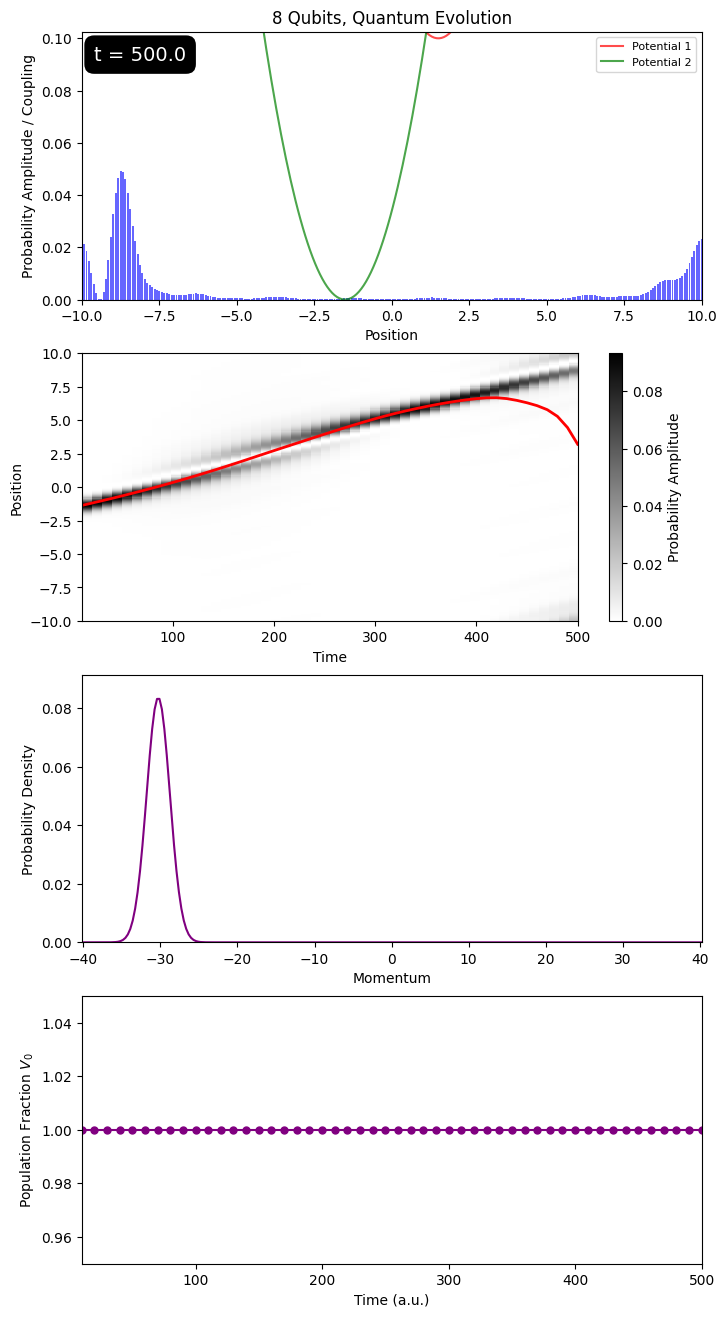

An error occurred in the main function: 2025-05-04_8q_trotter_statevectors_marcus_timestep10.0_x01.5_p0-30.0_t3.0_alpha0.1.txt not found.


Traceback (most recent call last):
  File "/tmp/ipykernel_2512956/3699017032.py", line 542, in <module>
    initial_comparison = calculate_inner_product_final_states(trotter_sv_filename, vff_sv_filename)
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2512956/3377884077.py", line 31, in calculate_inner_product_final_states
    trotter_time, trotter_state = load_final_statevector(trotter_filename)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2512956/3377884077.py", line 11, in load_final_statevector
    data = np.loadtxt(filename, delimiter='\t')
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jmc03846/.local/lib/python3.11/site-packages/numpy/lib/_npyio_impl.py", line 1397, in loadtxt
    arr = _read(fname, dtype=dtype, comment=comment, delimiter=delimiter,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jm

In [36]:
import multiprocessing as mp
import numpy as np
import time
import os
import traceback
from scipy.optimize import minimize
from functools import partial
import matplotlib.pyplot as plt

# Modify the filename definition for multiple phase parameters
phase_params_filename = f"{current_date}_{QUBITS_NUM}q_robust_phase_parameters_timestep{timestep}_x0{x_0}_p0{p_0}_t{trial}_alpha{diabaticity}.txt"

def optimize_single_timestep(trotter_filename, timestep_num, method='L-BFGS-B'):
    try:
        # Load trotter statevector for this timestep
        data = np.loadtxt(trotter_filename, delimiter='\t')
        trotter_time = data[timestep_num, 0]
        trotter_state = data[timestep_num, 1:]
        
        # In optimize_single_timestep, modify the parameters setup
        # Add relationships between parameters based on qubit position
        def get_initial_guess(timestep_num):
            # Start with decreasing values for higher qubits
            initial_guess = np.zeros(QUBITS_NUM)
            for i in range(QUBITS_NUM):
                #initial_guess[i] = (-0.037652825*timestep_num-(0.01461936*(i+1) + 0.1459514)*(2**i))
                initial_guess[i] = (-0.1 * timestep_num - 0.15)* (2**i)  # Exponential decrease
            return initial_guess

        # Update the optimization to use the better initial guess
        initial_betas = get_initial_guess(timestep_num)

        # You could also add parameter constraints
        # For example, enforce that higher qubits have smaller magnitudes
        bounds = []
        for i in range(QUBITS_NUM):
            bounds.append((-np.pi*(2**QUBITS_NUM), np.pi*(2**QUBITS_NUM)))
        
        print(f"Process {os.getpid()}: Optimizing timestep {timestep_num} (time = {trotter_time:.1f} a.u.)")
        
        # Define objective function for this specific timestep
        def objective(betas):
            # Run the VFF circuit with these phase parameters
            τ = timestep
            total_qubits = QUBITS_NUM + ANCILLA_QUBITS + COMPARISON_QUBITS
            
            current_time = (timestep_num+1) * τ
            initial_state = initialize_gaussian_wavepacket(x_0=x_0, p_0=p_0, δ=δ)
            psi = np.zeros(2**total_qubits, dtype=complex)
            psi[:2**QUBITS_NUM] = initial_state
            
            # Create circuit
            circuit = QuantumCircuit(position_register, ancilla_register, comparison_register)
            all_qubits = list(position_register) + list(ancilla_register) + list(comparison_register)
            circuit.initialize(psi, all_qubits)
            
            # Apply VFF evolution
            cqft(circuit, position_register, QUBITS_NUM)
            
            # Apply individual phase to each qubit
            for qubit in range(QUBITS_NUM):
                circuit.p(betas[qubit], position_register[qubit])
            
            apply_kinetic_term(circuit, kinetic_params, timestep_num, τ)
            ciqft(circuit, position_register, QUBITS_NUM)
            
            # Get final state
            simulator = Aer.get_backend('statevector_simulator')
            result = simulator.run(circuit).result()
            current_state = Statevector(result.get_statevector())
            
            # Extract position register state
            ancilla_start_idx = QUBITS_NUM
            rho_position = isolate_position_density_matrix(
                current_state,
                ancilla_indices=tuple(range(ancilla_start_idx, ancilla_start_idx + ANCILLA_QUBITS)),
                comparison_indices=tuple(range(ancilla_start_idx + ANCILLA_QUBITS, total_qubits))
            )
            
            vff_state = np.real(np.diag(rho_position.data))
            
            # Normalize both states
            trotter_norm = trotter_state / np.sqrt(np.sum(np.abs(trotter_state)**2))
            vff_norm = vff_state / np.sqrt(np.sum(np.abs(vff_state)**2))
            
            # Calculate inner product and fidelity
            inner_product = np.sum(np.conj(trotter_norm) * vff_norm)
            fidelity = np.abs(inner_product)**2
            
            # Return negative fidelity for minimization
            return -fidelity
        
        # Calculate initial fidelity (with zero phases)
        init_fidelity = -objective(np.zeros(QUBITS_NUM))
        
        # Set bounds for the parameters
        bounds = [(-np.pi*2**QUBITS_NUM, np.pi*2**QUBITS_NUM) for _ in range(QUBITS_NUM)]
        
        # Perform optimization with retry mechanism
        max_retries = 3
        for retry in range(max_retries):
            try:
                start_time = time.time()
                result = minimize(objective, initial_betas, method=method, bounds=bounds,
                               options={'disp': False, 'maxiter': 200})
                optimization_time = time.time() - start_time
                break
            except Exception as e:
                print(f"Process {os.getpid()}: Retry {retry+1}/{max_retries} for timestep {timestep_num} due to: {e}")
                if retry == max_retries - 1:
                    raise
                time.sleep(1)  # Brief pause before retry
        
        # Get optimal betas
        optimal_betas = result.x
        
        # Calculate final fidelity with optimized betas
        optimal_fidelity = -result.fun
        
        print(f"Process {os.getpid()}: Completed timestep {timestep_num} (time = {trotter_time:.1f} a.u.)")
        print(f"  Initial fidelity: {init_fidelity:.10f}")
        print(f"  Optimal fidelity: {optimal_fidelity:.10f}")
        print(f"  Optimization time: {optimization_time:.2f} seconds")
        
        return {
            'timestep': timestep_num,
            'time': trotter_time,
            'initial_fidelity': init_fidelity,
            'optimal_betas': optimal_betas,  # Array of 8 values
            'optimal_fidelity': optimal_fidelity,
            'optimization_time': optimization_time,
            'converged': result.success,
            'message': result.message
        }
    except Exception as e:
        print(f"Process {os.getpid()}: Error processing timestep {timestep_num}: {e}")
        traceback.print_exc()
        return None

def run_sequential_optimizations(trotter_filename, num_timesteps, method='L-BFGS-B'):
    print(f"\nRunning sequential optimizations for {num_timesteps} timesteps...")
    
    results = []
    for timestep_num in range(num_timesteps):
        result = optimize_single_timestep(trotter_filename, timestep_num, method)
        if result is not None:
            results.append(result)
            
            # Write results to file incrementally
            with open(phase_params_filename, 'a') as f:
                line = f"{result['time']}\t" + "\t".join(f"{beta:.10f}" for beta in result['optimal_betas']) + "\n"
                f.write(line)
    
    return results
    
def optimize_and_save_result(trotter_filename, timestep_num, method, output_filename):
    try:
        result = optimize_single_timestep(trotter_filename, timestep_num, method)
        if result is not None:
            # Use a file lock to ensure atomic write
            lock_file = output_filename + '.lock'
            while os.path.exists(lock_file):
                time.sleep(0.1)
            
            try:
                # Create lock file
                with open(lock_file, 'w') as f:
                    f.write(str(os.getpid()))
                
                # Append to results file
                with open(output_filename, 'a') as f:
                    line = f"{timestep_num}\t{result['time']}\t"
                    line += "\t".join(f"{beta:.10f}" for beta in result['optimal_betas'])
                    line += "\n"
                    f.write(line)
            finally:
                # Remove lock file
                if os.path.exists(lock_file):
                    os.remove(lock_file)
    except Exception as e:
        print(f"Process {os.getpid()}: Error in optimize_and_save_result for timestep {timestep_num}: {e}")
        traceback.print_exc()

def load_results_from_file(filename):
    try:
        # Check if file exists and has content
        if not os.path.exists(filename) or os.path.getsize(filename) == 0:
            return []
        
        data = np.loadtxt(filename, delimiter='\t')
        
        # Handle the case of a single row
        if len(data.shape) == 1:
            data = data.reshape(1, -1)
        
        results = []
        for row in data:
            timestep_num = int(row[0])
            time_value = row[1]
            
            # Debug: print row shape and content
            #print(f"Debug: Row {timestep_num}: shape={row.shape}, content={row}")
            
            # Check if we have enough columns for 8 betas
            if len(row) >= 2 + QUBITS_NUM:
                betas = row[2:2+QUBITS_NUM]  # 8 beta values
            else:
                # Handle case where file might not have all 8 values
                print(f"Warning: Row {timestep_num} has only {len(row)} columns, expected at least {2+QUBITS_NUM}")
                betas = np.zeros(QUBITS_NUM)  # Default to zeros if not all betas are saved
            
            # We don't have all information from the file, so reconstruct what we can
            results.append({
                'timestep': timestep_num,
                'time': time_value,
                'optimal_betas': betas,  # Array of 8 values
                # Other fields will be computed when needed
            })
        
        return results
    except Exception as e:
        print(f"Error loading results from {filename}: {e}")
        traceback.print_exc()
        return []

def run_check_and_fix(trotter_filename, phase_params_filename, method='L-BFGS-B'):
    # Load data to get number of timesteps
    data = np.loadtxt(trotter_filename, delimiter='\t')
    num_timesteps = data.shape[0]
    
    # Check if phase params file exists
    if not os.path.exists(phase_params_filename) or os.path.getsize(phase_params_filename) == 0:
        print(f"No phase parameters file found or file is empty. Running batch optimizations.")
        return run_batch_optimizations(trotter_filename, num_timesteps, batch_size=8, method=method)
    
    # Load existing results
    try:
        existing_results = load_results_from_file(phase_params_filename)
        existing_timesteps = set(result['timestep'] for result in existing_results)
        
        # Identify missing timesteps
        missing_timesteps = [t for t in range(num_timesteps) if t not in existing_timesteps]
        
        if not missing_timesteps:
            print(f"All {num_timesteps} timesteps have been optimized. No need to run additional optimizations.")
            return existing_results
        
        print(f"Found {len(existing_timesteps)} completed timesteps. {len(missing_timesteps)} timesteps missing.")
        print(f"Missing timesteps: {missing_timesteps}")
        
        # Re-run for missing timesteps
        for timestep_num in missing_timesteps:
            print(f"Running optimization for missing timestep {timestep_num}")
            result = optimize_single_timestep(trotter_filename, timestep_num, method)
            if result is not None:
                existing_results.append(result)
                
                # Append to file
                with open(phase_params_filename, 'a') as f:
                    line = f"{timestep_num}\t{result['time']}\t"
                    line += "\t".join(f"{beta:.10f}" for beta in result['optimal_betas'])
                    line += "\n"
                    f.write(line)
        
        # Sort and rewrite the file to ensure it's in timestep order
        existing_results.sort(key=lambda x: x['timestep'])
        with open(phase_params_filename, 'w') as f:
            for result in existing_results:
                line = f"{result['timestep']}\t{result['time']}\t"
                line += "\t".join(f"{beta:.10f}" for beta in result['optimal_betas'])
                line += "\n"
                f.write(line)
        
        return existing_results
        
    except Exception as e:
        print(f"Error checking phase parameters file: {e}")
        print("Removing potentially corrupted file and running all optimizations.")
        if os.path.exists(phase_params_filename):
            os.remove(phase_params_filename)
        return run_sequential_optimizations(trotter_filename, num_timesteps, method)

def convert_results_to_standard_format(results):
    # Check if trotter file exists before loading
    if not os.path.exists(trotter_sv_filename):
        print(f"Error: Trotter statevector file {trotter_sv_filename} not found!")
        return []
    
    # Load trotter data to calculate fidelities
    data = np.loadtxt(trotter_sv_filename, delimiter='\t')
    
    # Check data shape
    #print(f"Debug: Trotter data shape: {data.shape}")
    
    standard_results = []
    for result in results:
        timestep_num = int(result['timestep'])
        
        # Get trotter state for this timestep
        trotter_state = data[timestep_num, 1:]
        
        # Calculate the fidelity using the optimal betas
        try:
            # Run VFF with these parameters to get the state
            vff_state = vff_with_multi_phase_timestep(result['optimal_betas'], timestep_num)
            
            # Normalize both states
            trotter_norm = trotter_state / np.sqrt(np.sum(np.abs(trotter_state)**2))
            vff_norm = vff_state / np.sqrt(np.sum(np.abs(vff_state)**2))
            
            # Calculate fidelity
            inner_product = np.sum(np.conj(trotter_norm) * vff_norm)
            optimal_fidelity = np.abs(inner_product)**2
            
            # Calculate initial fidelity (with zero phases)
            init_state = vff_with_multi_phase_timestep(np.zeros(QUBITS_NUM), timestep_num)
            init_norm = init_state / np.sqrt(np.sum(np.abs(init_state)**2))
            init_inner_product = np.sum(np.conj(trotter_norm) * init_norm)
            init_fidelity = np.abs(init_inner_product)**2
            
        except Exception as e:
            print(f"Error calculating fidelity for timestep {timestep_num}: {e}")
            import traceback
            traceback.print_exc()
            optimal_fidelity = 0.0
            init_fidelity = 0.0
        
        # Create standard format result
        standard_result = {
            'timestep': timestep_num,
            'time': result['time'],
            'initial_fidelity': init_fidelity,
            'optimal_fidelity': optimal_fidelity,
            'optimal_betas': result['optimal_betas'],
            'converged': True  # Assume success since we have results
        }
        standard_results.append(standard_result)
    
    return standard_results

def plot_optimization_results(results):
    if not results:
        print("No results to plot.")
        return
    
    # Extract data for plotting
    times = [result['time'] for result in results]
    initial_fidelities = [result.get('initial_fidelity', 0) for result in results]
    optimal_fidelities = [result.get('optimal_fidelity', 0) for result in results]
    
    # Filter out zeros (failed optimizations)
    valid_indices = [i for i, (init, opt) in enumerate(zip(initial_fidelities, optimal_fidelities)) 
                    if init > 0 and opt > 0]
    
    if not valid_indices:
        print("No valid fidelity results to plot.")
        return
    
    valid_times = [times[i] for i in valid_indices]
    valid_init_fidelities = [initial_fidelities[i] for i in valid_indices]
    valid_opt_fidelities = [optimal_fidelities[i] for i in valid_indices]
    
    # Plot fidelities
    plt.figure(figsize=(10, 6))
    plt.plot(valid_times, valid_init_fidelities, 'o-', label='Initial Fidelity')
    plt.plot(valid_times, valid_opt_fidelities, 's-', label='Optimized Fidelity')
    plt.xlabel('Time (a.u.)')
    plt.ylabel('Fidelity')
    plt.title('Fidelity Improvement from Phase Optimization')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add improvement percentage to plot if there are valid results
    if valid_init_fidelities and valid_opt_fidelities:
        improvements = [(opt - init) * 100 for init, opt in zip(valid_init_fidelities, valid_opt_fidelities)]
        avg_improvement = sum(improvements) / len(improvements)
        plt.text(0.05, 0.05, f'Average improvement: {avg_improvement:.2f}%', 
                transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # Save the plot
    plt.savefig(f"{current_date}_{QUBITS_NUM}q_fidelity_improvement.png", dpi=300)
    plt.close()
    
    # Plot optimal phases for each qubit
    plt.figure(figsize=(12, 8))
    for qubit in range(QUBITS_NUM):
        plt.subplot(2, 4, qubit+1)
        
        # Extract phase data for this qubit
        qubit_phases = []
        qubit_times = []
        for i, result in enumerate(results):
            if i in valid_indices and 'optimal_betas' in result:
                qubit_phases.append(result['optimal_betas'][qubit])
                qubit_times.append(times[i])
        
        if qubit_phases:
            plt.plot(qubit_times, qubit_phases, 'o-')
            plt.title(f'Qubit {qubit}')
            plt.xlabel('Time (a.u.)')
            plt.ylabel('Phase (rad)')
            plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{current_date}_{QUBITS_NUM}q_optimal_phases.png", dpi=300)
    plt.close()

def run_batch_optimizations(trotter_filename, num_timesteps, batch_size=8, method='L-BFGS-B'):
    print(f"\nRunning optimizations in batches of {batch_size} for {num_timesteps} timesteps...")
    
    # Clear the output file
    with open(phase_params_filename, 'w') as f:
        f.write('')
    
    results = []
    
    # Process timesteps in batches
    for batch_start in range(0, num_timesteps, batch_size):
        batch_end = min(batch_start + batch_size, num_timesteps)
        print(f"\nProcessing batch: timesteps {batch_start} to {batch_end-1}")
        
        # Create and start processes for this batch
        processes = []
        for timestep_num in range(batch_start, batch_end):
            p = mp.Process(target=optimize_and_save_result, 
                          args=(trotter_filename, timestep_num, method, phase_params_filename))
            processes.append(p)
            p.start()
        
        # Wait for all processes in this batch to complete
        for p in processes:
            p.join()
        
        # Load the results from the file after each batch
        batch_results = load_results_from_file(phase_params_filename)
        results.extend(batch_results)
        
        print(f"Completed batch: timesteps {batch_start} to {batch_end-1}")
    
    # Sort results by timestep
    results.sort(key=lambda x: x['timestep'])
    
    return results

# Modified main function to include robust parallel optimization
if __name__ == '__main__':
 #   trotter_statevectors_evolved = trotter_main()
  #  create_quantum_evolution_animation(
   #     statevector_filename=trotter_sv_filename,
    #    ancilla_filename=trotter_anc_filename,
   #     momentum_filename=trotter_mom_filename,
  #      QUBITS_NUM=QUBITS_NUM,
 #       timestep=timestep,
 #       trial=trial,
 #       method="trotter"
 #   )
    
    vff_statevectors_evolved = vff_main()
    create_quantum_evolution_animation(
        statevector_filename=vff_sv_filename,
        ancilla_filename=vff_anc_filename,
        momentum_filename=vff_mom_filename,
        QUBITS_NUM=QUBITS_NUM,
        timestep=timestep,
        trial=trial,
        method="vff"
    )

    try:
        # Calculate initial fidelity before optimization
        initial_comparison = calculate_inner_product_final_states(trotter_sv_filename, vff_sv_filename)
        print_final_state_comparison(initial_comparison)
        
        # Check if trotter file exists
        if not os.path.exists(trotter_sv_filename):
            print(f"Error: Trotter statevector file {trotter_sv_filename} not found!")
            exit(1)
        
        # Get number of timesteps from file
        data = np.loadtxt(trotter_sv_filename, delimiter='\t')
        num_timesteps = data.shape[0]
        
        # Run check and fix - this will run only the missing optimizations if any
        print(f"Checking for existing optimizations and running any missing ones...")
        start_time = time.time()
        
        # Determine batch size based on number of CPU cores
        cpu_count = mp.cpu_count()
        batch_size = min(cpu_count, 8)  # Limit to 8 processes at a time for stability
        print(f"Detected {cpu_count} CPU cores. Using batch size of {batch_size}.")

        # Run the optimization (only runs once for each timestep)
        results = run_check_and_fix(trotter_sv_filename, phase_params_filename, 'L-BFGS-B')
        
        total_time = time.time() - start_time
        
        # Convert results to standard format for visualization
        if results:
            standard_results = convert_results_to_standard_format(results)
            
            print(f"\nOptimization completed in {total_time:.2f} seconds")
            print(f"Results saved to: {phase_params_filename}")
            
            # Visualize the optimization results
            #plot_optimization_results(standard_results)
            
            # Print summary of optimization results
            print("\nPhase Optimization Summary:")
            for result in standard_results:
                init_fid = result.get('initial_fidelity', 0)
                opt_fid = result.get('optimal_fidelity', 0)
                improvement = (opt_fid - init_fid) * 100 if init_fid > 0 else 0
                print(f"Time: {result['time']:.1f} a.u., Initial: {init_fid:.8f}, "
                    f"Optimal: {opt_fid:.8f}, Improvement: {improvement:.2f}%")
            
            # Run phase-corrected VFF simulation
            pvff_statevectors_evolved = phase_corrected_vff_main()
            
            # Create animation of phase-corrected results if we have results
            if pvff_statevectors_evolved:
                create_quantum_evolution_animation(
                    statevector_filename=pvff_sv_filename,
                    ancilla_filename=pvff_anc_filename,
                    momentum_filename=pvff_mom_filename,
                    QUBITS_NUM=QUBITS_NUM,
                    timestep=timestep,
                    trial=trial,
                    method="robust_phase_corrected_vff"
                )
                
                # Calculate final fidelity after phase correction
                final_comparison = calculate_inner_product_final_states(trotter_sv_filename, pvff_sv_filename)
                print("\nFidelity Comparison After Robust Multi-Parameter Phase Optimization:")
                print_final_state_comparison(final_comparison)
        else:
            print("No optimization results available. Cannot proceed with phase-corrected simulation.")
    except Exception as e:
        print(f"An error occurred in the main function: {e}")
        traceback.print_exc()